In [ ]:
!pip install yfinance
!pip install ta

In [2]:
import pandas as pd, numpy as np
import seaborn as sns
import yfinance as yf

from copy import copy
import statistics as stats
import math
from functools import reduce

from ta.volume import MFIIndicator
from ta.volatility import AverageTrueRange
from ta.trend import STCIndicator
from ta.trend import EMAIndicator

# Import des données historiques

In [3]:
ndx = yf.Ticker("^NDX")
df_historical_data = ndx.history(interval="1d", period="max")
df_historical_data.drop(columns=["Dividends","Stock Splits"], inplace=True)
df_historical_data.reset_index(inplace=True)

In [4]:
df_historical_data.describe()

,Open,High,Low,Close,Volume
count,9471.000000,9471.000000,9471.000000,9471.000000,9.471000e+03
mean,2932.782685,2957.312734,2906.764657,2933.410814,1.612036e+09
std,3558.062177,3585.873086,3527.588723,3558.660670,1.291157e+09
min,107.160004,108.269997,106.750000,107.160004,3.174000e+07
25%,424.785004,428.410004,423.524994,425.240005,4.722000e+08
50%,1638.380005,1657.530029,1624.800049,1640.339966,1.664350e+09
75%,3709.569946,3755.944946,3664.810059,3707.185059,2.069455e+09
max,16644.769531,16764.859375,16523.830078,16573.339844,1.162119e+10


In [5]:
# Test si aucune ligne manquante
test_list = [champ == 0 for champ in df_historical_data.isnull().sum()]

# Si toutes les colonnes sont True, résultat = True
res1 = all(i for i in test_list)
res1

True

In [6]:
df_historical_data.tail(1)

,Date,Open,High,Low,Close,Volume
9470,2023-04-28 00:00:00-04:00,13139.349609,13247.389648,13096.94043,13245.990234,5331380000


In [7]:
df_historical_data.dtypes

Date      datetime64[ns, America/New_York]
Open                               float64
High                               float64
Low                                float64
Close                              float64
Volume                               int64
dtype: object

# Indicateurs techniques

### Alphatrend

In [8]:
# Trend indicator, équivalent de l'affichage couleur
def trend_indicator(trend):
    if trend > 0 :
        # Uptrend
        x = 1
    elif trend < 0 :
        # Downtrend
        x = -1
    else :
        # Range
        x = 0
    return x

In [9]:
# Defintion fonction
def generate_alphatrend(df_in, mfi_p, mfi_seuil, atr_l, m):
    '''Paramètres d'entrée : longueur MFI, longueur ATR, multiplier
    Retourne les colonnes Alphatrend, Alphatrend +2, Trend (position AT1 / AT2)
    :mfi_p = période MFI servant à délimiter up/down de l'alphatrend
    :mfi_seuil = période MFI pour recherche crossover, détermine uptrend ou downtrend'''

    df = df_in.copy()

    # Colonnes MFI
    s_mfi = MFIIndicator(high=df.High, low=df.Low, close=df.Close, volume=df.Volume, window=mfi_p).money_flow_index()
    df["MFI_ref"] = s_mfi

    # Colonne ATR
    s_atr = AverageTrueRange(high=df.High, low=df.Low, close=df.Close, window=atr_l).average_true_range()
    df["ATR"] = s_atr

    # Lignes UpT et DownT
    df["UpT_support"] = df["Low"] - df["ATR"] * m
    df["DownT_support"] = df["High"] + df["ATR"] * m

    # Suppression des lignes sans signal, en début de DataFrame
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)

    # ===============================================
    # Calcul Alphatrend, en tant que série
    
    Alphatrend = [0]

    for i in range (1, df.shape[0]):
        # Cas Uptrend
        if df.at[i,"MFI_ref"] >= mfi_seuil :
            if df.at[i,"UpT_support"] < Alphatrend[-1] :
                # Flat
                Alphatrend.append(Alphatrend[-1])
            else :
                # Trailing stop loss Up
                Alphatrend.append(df.at[i,"UpT_support"])

        # Cas Downtrend, MFI < 50
        else :
            if df.at[i,"DownT_support"] > Alphatrend[-1] :
                # Flat
                Alphatrend.append(Alphatrend[-1])
            else :
                # Trailing stop loss Down
                Alphatrend.append(df.at[i,"DownT_support"])

    # ===============================================
    # Ajout des lignes k1 et k2 en tant que colonnes
    
    if df.shape[0] == len(Alphatrend):
        df["Alphatrend_k1"] = pd.Series(Alphatrend).apply(lambda x: round(x,2))
        # Ligne k2 décalée de 2j
        Alphatrend2 = df["Alphatrend_k1"].shift(periods=2, fill_value=0)
        df["Alphatrend_k2"] = pd.Series(Alphatrend2).apply(lambda x: round(x,2))
        # Trend
        df["Trend"] = df.Alphatrend_k1 - df.Alphatrend_k2
        df["Trend"] = df["Trend"].apply(trend_indicator)
    else :
        print("Erreur lors de la génération des lignes Alphatrend")

    # ===============================================
    # Génération des signaux Achat / Vente

    # On isole tous les index non neutres, où AT1 != AT2, à la hausse (1) comme à la baisse (-1)
    s_trend = df["Trend"].loc[df["Trend"]!=0]
    s_trend_diff = s_trend - s_trend.shift(1)

    buy_signal_indexes = s_trend_diff[s_trend_diff == 2].index
    sell_signal_indexes = s_trend_diff[s_trend_diff == -2].index

    df["Signal"] = 0
    df.loc[buy_signal_indexes,"Signal"] = 1
    df.loc[sell_signal_indexes,"Signal"] = -1

    # ===============================================
    # Spécification des colonnes avec les paramètres d'entrée
    params = "MFIp = " + str(mfi_p) + ", MFItrigger = " + str(mfi_seuil) + ", ATR = " + str(atr_l) + ", m = " + str(m)
    # Sélection des colonnes suffisantes
    df = df[["Date","Alphatrend_k1","Alphatrend_k2","Trend","Signal"]]
    
    return df, params

In [10]:
df_AT, parametres_AT = generate_alphatrend(df_historical_data, mfi_p=14, mfi_seuil=50, atr_l=13, m=0.2)

In [11]:
# Servira à stocker les paramètres testés pour identifier la meilleure combinaison
print(parametres_AT)

MFIp = 14, MFItrigger = 50, ATR = 13, m = 0.2


In [12]:
df_AT.tail(1)

,Date,Alphatrend_k1,Alphatrend_k2,Trend,Signal
9457,2023-04-28 00:00:00-04:00,12968.72,12968.72,0,0


### STC & EMA

In [13]:
def generate_STC_and_EMA(df_in, stc_length, fast_length, slow_length, ema_period):
  
  df = df_in[["Date","Close"]].copy()

  s_stc = STCIndicator(close=df.Close, window_slow=slow_length, window_fast=fast_length, cycle=stc_length).stc()
  s_ema = EMAIndicator(close=df.Close, window=ema_period).ema_indicator()

  df["STC"] = round(s_stc,2)
  df["EMA"] = round(s_ema,2)

  params = "STC Length = " + str(stc_length) + ", Fast Length = " + str(fast_length) + ", Slow Length = " + str(slow_length) + ", EMA length = " + str(ema_period)

  df.drop(columns=["Close"], inplace=True)

  return df, params

In [14]:
df_STC_EMA, params_STC_EMA = generate_STC_and_EMA(df_historical_data, stc_length=130, fast_length=25, slow_length=125, ema_period=70)

In [15]:
# Servira à stocker les paramètres testés pour identifier la meilleure combinaison
print(params_STC_EMA)

STC Length = 130, Fast Length = 25, Slow Length = 125, EMA length = 70


In [16]:
df_STC_EMA.tail(1)

,Date,STC,EMA
9470,2023-04-28 00:00:00-04:00,98.13,12527.19


### Merge et export du Dataset contenant l'ensemble des indicateurs techniques

In [17]:
df_essentials = df_historical_data.copy()

# Ajout de la colonne ATR qui servira plus tard dans le calcul de la sortie.
s_atr = AverageTrueRange(high=df_essentials.High, low=df_essentials.Low, close=df_essentials.Close, window=14).average_true_range()
df_essentials["ATR"] = s_atr

# Réduction au strict nécessaire pour les colonnes
df_essentials = df_essentials[["Date","Open","Close","ATR"]].copy()

df_essentials["Open"] = df_essentials.Open.apply(lambda x: round(x,2))
df_essentials["Close"] = df_essentials.Close.apply(lambda x: round(x,2))
df_essentials["ATR"] = df_essentials.ATR.apply(lambda x: round(x,2))

In [18]:
data_frames = [df_essentials, df_AT, df_STC_EMA]
df_IT = reduce(lambda  left,right: pd.merge(left,right, on=['Date'], how='left'), data_frames)

In [19]:
df_IT = df_IT.loc[df_IT["Date"]>="1998-01-01"]

In [20]:
df_IT.head(1)

,Date,Open,Close,ATR,Alphatrend_k1,Alphatrend_k2,Trend,Signal,STC,EMA
3099,1998-01-02 00:00:00-05:00,990.8,1008.23,24.18,959.34,959.34,0.0,0.0,0.21,1031.32


In [21]:
df_IT["Trend"].value_counts()

 0.0    3044
 1.0    2134
-1.0    1194
Name: Trend, dtype: int64

In [22]:
df_IT.reset_index(drop=True,inplace=True)

In [23]:
# Test si aucune ligne manquante
test_list = [champ == 0 for champ in df_historical_data.isnull().sum()]
test_list2 = [champ == 0 for champ in df_historical_data.isna().sum()]

# Si toutes les colonnes sont True, résultat = True
res1 = all(i for i in test_list)
res2 = all(i for i in test_list2)

if res1 and res2 :
  print("Ok pour Backtesting")
else :
  print("Anomalies détectées")

Ok pour Backtesting


In [24]:
# Export
#df_IT.to_csv("/content/drive/MyDrive/Colab Notebooks/sources/TradingView_strategies/AT_STC_EMA_indicateurs_optimised_short.csv", header=True, index=False)

# Backtesting

## Détection des entrées

Stratégie :<br>
<li>Entreée : Buy signal + Prix > EMA + STC < seuil(25)</li>
<li>Sortie : Sell signal + Prix < EMA + STC > seuil(75)</li>

In [25]:
stc_seuil_bas = 25
# Valeur 3 pour signaux d'entrée valides
df_IT["Buy_entry"] = np.sign(df_IT.Close - df_IT.EMA) + df_IT.Signal + np.sign(stc_seuil_bas - df_IT.STC)

stc_seuil_haut = 75
# Valeur -3 pour signaux d'entrée valides
# Attention / par deux signaux négatifs -> positif, d'où l'inversion sur un seul champ
df_IT["Sell_entry"] = np.sign(df_IT.Close - df_IT.EMA) + df_IT.Signal + np.sign(stc_seuil_haut - df_IT.STC)

In [26]:
# Conversion en np array
arr_buy_entry = df_IT["Buy_entry"].to_numpy()
# np.where(condition, vrai, sinon)
df_IT["Buy_entry"] = np.where(arr_buy_entry==3, 1, 0)

arr_sell_entry = df_IT["Sell_entry"].to_numpy()
df_IT["Sell_entry"] = np.where(arr_sell_entry==-3.0, -1, 0)

In [27]:
'''Agrégation dans une seule colonne "Entrées"
1 pour Buy -1 pour Sell
Ne sera peut-être pas conservé si paramètres différents entre Stratégie Short ou Long.
Il ne sera pas possible de générer les deux en même temps'''

df_IT["Entry"] = df_IT["Sell_entry"] + df_IT["Buy_entry"]
df_IT["Entry"].value_counts()

 0    6300
 1      50
-1      22
Name: Entry, dtype: int64

In [28]:
df_IT.drop(columns=["Buy_entry","Sell_entry"], inplace=True)
df_IT.tail(1)

,Date,Open,Close,ATR,Alphatrend_k1,Alphatrend_k2,Trend,Signal,STC,EMA,Entry
6371,2023-04-28 00:00:00-04:00,13139.35,13245.99,205.28,12968.72,12968.72,0.0,0.0,98.13,12527.19,0


In [29]:
df_IT.loc[ df_IT["Entry"]==-1 ].index

Int64Index([ 781,  857,  869,  892,  908, 1244, 1272, 1942, 2804, 3493, 3511,
            3807, 3890, 4266, 4515, 4529, 5055, 5224, 5572, 6205, 6280, 6337],
           dtype='int64')

# Mesure de la performance

### Isolement des entrées

In [30]:
short_entries_indexes = df_IT.loc[ df_IT["Entry"]==-1 ].index
# Ajout d'une unité pour entrée le lendemain du signal confirmé et clos
short_entries_indexes += 1

short_entries_indexes = short_entries_indexes.to_list()
print(short_entries_indexes)

[782, 858, 870, 893, 909, 1245, 1273, 1943, 2805, 3494, 3512, 3808, 3891, 4267, 4516, 4530, 5056, 5225, 5573, 6206, 6281, 6338]


In [31]:
# 1ère entrée de la liste
index_min = short_entries_indexes[0]

# Dernier index du dataframe
index_max = max(df_IT.index)

print("Sélection des lignes entre {} et {}".format(index_min,index_max))

Sélection des lignes entre 782 et 6371


In [32]:
df_short_entries = df_IT.loc[index_min:index_max]
df_short_entries = df_short_entries[['Date','Open','Close','ATR']].copy()

### Conditions de sortie
2 ATR en stop Loss, 1:3 en Risk Reward

In [33]:
def generate_exit_vars(df_entries, entry_index):
  ''' Obtient l'Open de l'index d'entrée.
  Puis génère la valeur du Stop Loss et Take Profit'''

  df = df_entries.copy()

  entree_reference = df.at[entry_index,"Open"]
  atr_reference = df.at[entry_index,"ATR"]

  stop_loss = entree_reference + 2 * atr_reference
  take_profit = entree_reference - 3 * (2 * atr_reference)

  return stop_loss, take_profit, entree_reference

In [34]:
# Test fonctionnement de la fonction
a, b, c = generate_exit_vars(df_short_entries, 782)
print("Stop Loss : {}, Take Profit : {}".format(a,b))
# Validé

Stop Loss : 2678.62, Take Profit : 1710.06


In [35]:
def return_SL_or_TP_index(df_entries, entry_index, stop_loss, take_profit) :
  '''Serie des valeurs close entre entrée et -1 de la suivante
  Si Close > Stop loss, dans le cas d'un Short, alors touché.
  On cherche alors l'index de la première valeur >=0, si il existe'''

  df = df_entries.copy()

  last_line = max(df.index)

  # Index Stop Loss, ou index max df
  close_series = (df.loc[entry_index:last_line,"Close"] - stop_loss) >= 0
  if len(close_series[ close_series == True ]) > 0 :
    sl_index = close_series[ close_series == True ].index[0]
  else :
    # Pour la dernière entrée, si rien n'est touché, alors la dernière ligne fera office de sortie
    sl_index = max(df.index)

  # Index Take Profit
  close_series = (take_profit - df.loc[entry_index:last_line,"Close"]) >= 0
  if len(close_series[ close_series == True ]) > 0 :
    tp_index = close_series[ close_series == True ].index[0]
  else :
    tp_index = max(df.index)
 
  
  lowest_index = min(sl_index, tp_index)
  exit_position = df.at[lowest_index,"Close"]

  return exit_position

In [36]:
out = return_SL_or_TP_index(df_short_entries, 782, a, b)
print(out)
# Validé, Close Take Profit à index 803, gain, pour entrée 782 avec Open 2436

1680.64


### Métriques de performance (adaptés à Short)

In [37]:
def calc_perf(entree, cloture):
  '''Calcule la performance en % entrée l'Open à index d'entrée,
  et le Close en index de Take Profit ou Stop loss de l'entrée considérée.
  ATTENTIONS : Performance valide pour SHORT -> Cloture < Entrée'''

  return round( -((cloture-entree)/entree), 3)

In [38]:
calc_perf(c, out)

0.31

In [39]:
%time

list_perf = []

for entry in short_entries_indexes:

  # Calcul stop loss, take profit, et stocke Open de l'index d'entrée
  sl, tp, entry_price = generate_exit_vars(df_short_entries, entry)

  # Prix en sortie, que ce soit SL ou TP, ou dernière valeur du DataFrame
  exit_price = return_SL_or_TP_index(df_short_entries, entry, sl, tp)

  # Calcul de la performance et ajout à la liste
  list_perf.append( calc_perf(entry_price, exit_price) )

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.54 µs


In [40]:
print(list_perf)

[0.31, 0.313, 0.306, 0.263, 0.227, -0.075, -0.08, -0.024, -0.081, -0.048, -0.043, -0.027, -0.034, -0.042, -0.034, 0.108, -0.045, 0.087, 0.159, 0.133, -0.049, -0.042]


In [41]:
# Profit factor

a_perf = np.array(list_perf)

count_won = len( a_perf[a_perf > 0] )
count_lost = len(a_perf) - count_won
print("Win Rate : {:.2f}".format(count_won/len(a_perf)))

# Reward-to-Risk Ratio X Win Ratio) - (Loss Ratio) = Expectancy Ratio
expectancy_ratio = 3 * count_won/len(a_perf) - count_lost/len(a_perf)
print("Expectancy Ratio : {:.2f}".format(expectancy_ratio))

Win Rate : 0.41
Expectancy Ratio : 0.64


In [57]:
# Génère le gain ou la perte nette par rapport à 1000€ d'investissement
# Avec 1% de commission à l'entrée, et 1% de commission en sortie, 7 de Leverage
perf_nette_b1000 = [(999*(1+x*3)-1000)*0.99 for x in list_perf]
#perf_nette_b1000 = [(999*(1+x)-1000)*0.99 for x in list_perf]


arr_b1000 = np.array(perf_nette_b1000)
moyenne_gains_nets = np.mean(arr_b1000[ arr_b1000>0 ])
moyenne_pertes_nettes = np.mean(arr_b1000[ arr_b1000<0 ])
print("Avg_gain : {:.2f}, Avg_perte : {:.2f}".format(moyenne_gains_nets,moyenne_pertes_nettes))

expectancy = (count_won/len(a_perf) * moyenne_gains_nets) - (count_lost/len(a_perf) * moyenne_pertes_nettes)
print("Expectancy : {:.2f}".format(expectancy))

profit_factor = np.sum(arr_b1000[ arr_b1000>0 ]) / np.sum( np.abs(arr_b1000[ arr_b1000<0 ]) )
print("Profit Factor : {:.2f}".format(profit_factor))

Avg_gain : 627.36, Avg_perte : -143.41
Expectancy : 341.39
Profit Factor : 3.03


In [58]:
''' Leverage de 3 choisi avec les paramètres actuels car perte toujours inférieure à -250€
Attention : on a une série de 10 pertes ! 
Cf graphique, 5 gains nous font passer de 0 à 4000€ et 10 pertes baisser à 3000€'''
perf_nette_b1000

[918.7892999999999,
 927.6903900000001,
 906.9211799999998,
 779.3388900000002,
 672.52581,
 -223.51724999999996,
 -238.3524,
 -72.19872000000011,
 -241.31942999999995,
 -143.40743999999998,
 -128.57228999999998,
 -81.09980999999998,
 -101.86902000000002,
 -125.60526000000002,
 -101.86902000000002,
 319.44924000000015,
 -134.50635,
 257.14161,
 470.7677699999999,
 393.6249900000001,
 -146.37447000000006,
 -125.60526000000002]

<Axes: >

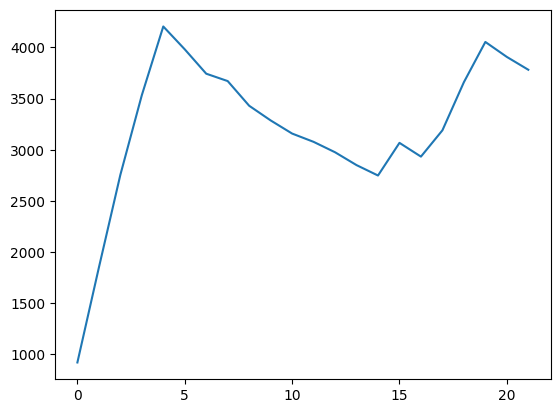

In [59]:
courbe_profit = np.cumsum(arr_b1000)
sns.lineplot(data=courbe_profit)

### Combinaisons possibles

In [61]:
a_ema = np.array( [e for e in range(40,88,2)] )
a_AT_period = np.array( [p for p in range(4,42,2)] )
a_STC_length = np.array( [l for l in range(98,132,2)] )
a_STC_slow = np.array( [s for s in range(98,132,2)] )

In [63]:
%time

W, X, Y, Z = np.meshgrid(a_ema, a_AT_period, a_STC_length, a_STC_slow)
combinations = np.column_stack( (W.ravel(), X.ravel(), Y.ravel(), Z.ravel()) )

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 9.06 µs


In [64]:
combinations.shape

(131784, 4)

In [71]:
combinations[0][0]

40

In [72]:
# 2e methode
import itertools

In [73]:
l_ema = [e for e in range(40,88,2)]
l_AT_period = [p for p in range(4,42,2)]
l_STC_length = [l for l in range(98,132,2)]
l_STC_slow = [s for s in range(98,132,2)]

all_params = [l_ema, l_AT_period, l_STC_length, l_STC_slow]

In [74]:
%time
res = list(itertools.product(*all_params))

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.34 µs


In [75]:
len(res)

131784

In [78]:
res[0][0]

40